In [1]:
%% Start afresh by clearing all command windows and variables
clear;
rng(1); % For reproducibility

In [2]:
basefolder = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/';

In [3]:
outputpath = [basefolder 'decArsousalDecisionmaking_JNeuroscience2021/Scripts/notebooks/pics/' ];

In [4]:
%% Load the paths..
run([basefolder 'decArsousalDecisionmaking_JNeuroscience2021/Scripts/loadpath_validation']);

In [5]:
%% Load the input files..
subj = '35';
session = 'drowsy'; %'awake''drowsy'
epoch = 'pre_trial';

In [6]:
%% 1. Preprocessed file..
S.eeg_filepath = [pathappend 'SpatialAttention_Drowsiness/SpatialAttention_Mechanisms/preprocessing/' epoch '/11_epoched_rereferenced'];
S.eeg_filename = ['s_' subj '_' session '_epoched_rereferenced'];

% load the preprocessed EEGdata set..
evalexp = 'pop_loadset(''filename'', [S.eeg_filename ''.set''], ''filepath'', S.eeg_filepath);';

[T,EEG] = evalc(evalexp);

hpfreq = 1;
fprintf('High-pass filtering above %dHz...\n',hpfreq);

evalexp = 'pop_eegfiltnew(EEG, hpfreq, 0);';

[T,EEG] = evalc(evalexp);

lpfreq = 30;
fprintf('Low-pass filtering below %dHz...\n',lpfreq);
evalexp = 'pop_eegfiltnew(EEG, 0, lpfreq);';

[T,EEG] = evalc(evalexp);

High-pass filtering above 1Hz...
Low-pass filtering below 30Hz...


In [7]:
%% 2. Alertness data
S.beh_filepath = [pathappend 'SpatialAttention_Drowsiness/SpatialAttention_Mechanisms/beh_data_comb/'];
S.beh_filename = ['comb_' 's_' subj '.mat'];
load([S.beh_filepath S.beh_filename], 'comb_behsession');

if strcmp(session,'awake')
    starttrial = 1;
    endtrial = 124;
else
    starttrial = 125;
    endtrial = 864;
end

selectrials = (comb_behsession.ovtrialsnos >= starttrial) & (comb_behsession.ovtrialsnos <= endtrial);
behtable = comb_behsession(selectrials,:);

In [8]:
%% 3. Compute time data
alleventstype =[];
alleventstime =[];
eventstimeindices = [];
trialtimes = [];
matchidx = 1;
for idx = 1:length(EEG.urevent)
    if strcmp(EEG.urevent(idx).type, 'tone')
        alleventstype{matchidx} = (EEG.urevent(idx).type);
        alleventstime{matchidx} = (EEG.urevent(idx).init_time);
        matchidx = matchidx+1;
        start_time = (EEG.urevent(idx).init_time);
        trialtimes = [trialtimes; start_time];
        eventstimeindices = [eventstimeindices; start_time:1/EEG.srate:(EEG.urevent(idx).init_time)];
        
    end
    
end

In [9]:
%% 4. Prune the events to usable events in EEG data
usableevents = ~strcmp(behtable.Alertness, 'NA');
usableeventtimes = eventstimeindices(usableevents,:);
usabletrialtimes = trialtimes(usableevents);
usablereactiontimes = behtable.RT(usableevents,:);
usableclassification = behtable.Alertness(usableevents,:);

In [10]:
%% 5. Select only stuff from occipetal electrodes
chanlabels={EEG.chanlocs.labels};
electrodes_occ = {'E75','E70','E83'};

selec_elec = ismember(chanlabels,electrodes_occ);
remove_elec = find(~selec_elec);%Use only selected electrodes..
evalexp = 'pop_select(EEG,''nochannel'',remove_elec);';
[T,EEG_occ] = evalc(evalexp);
EEG = EEG_occ;

dur = max(usabletrialtimes)+4; %(1/EEG.srate)* EEG.urevent(length(EEG.urevent)).latency

In [11]:
%% 6. Compute the power spectogram
meanPxx_plot = [];

for idx = 1:EEG.nbchan

    Data_x = squeeze(EEG.data(idx,:,:));
    x = double(Data_x(:));

    window_len = round(1*EEG.pnts);
    nsc = window_len;
    nov = floor(nsc/2);

    [s,f,t,Pxx,fcorr,tcorr] = spectrogram(x,hamming(nsc),nov,nsc,EEG.srate,'yaxis','power');

    time = linspace(min(usabletrialtimes),dur,size(s,2));
    time = time - min(usabletrialtimes); %reset everything to start from zero

    freqlist = [0 30];
    [~, fBeg] = min(abs(f-freqlist(1)));
    [~, fEnd] = min(abs(f-freqlist(2)));

    s_plot = s(fBeg:fEnd,:);
    f_plot = f(fBeg:fEnd);
    t_plot = t;
    Pxx_plot(:,:,idx) = 10*log10(abs(Pxx(fBeg:fEnd,:)));

end

Pxx_plot = mean(Pxx_plot,3);

In [14]:
%plot -w 1800 -h 900

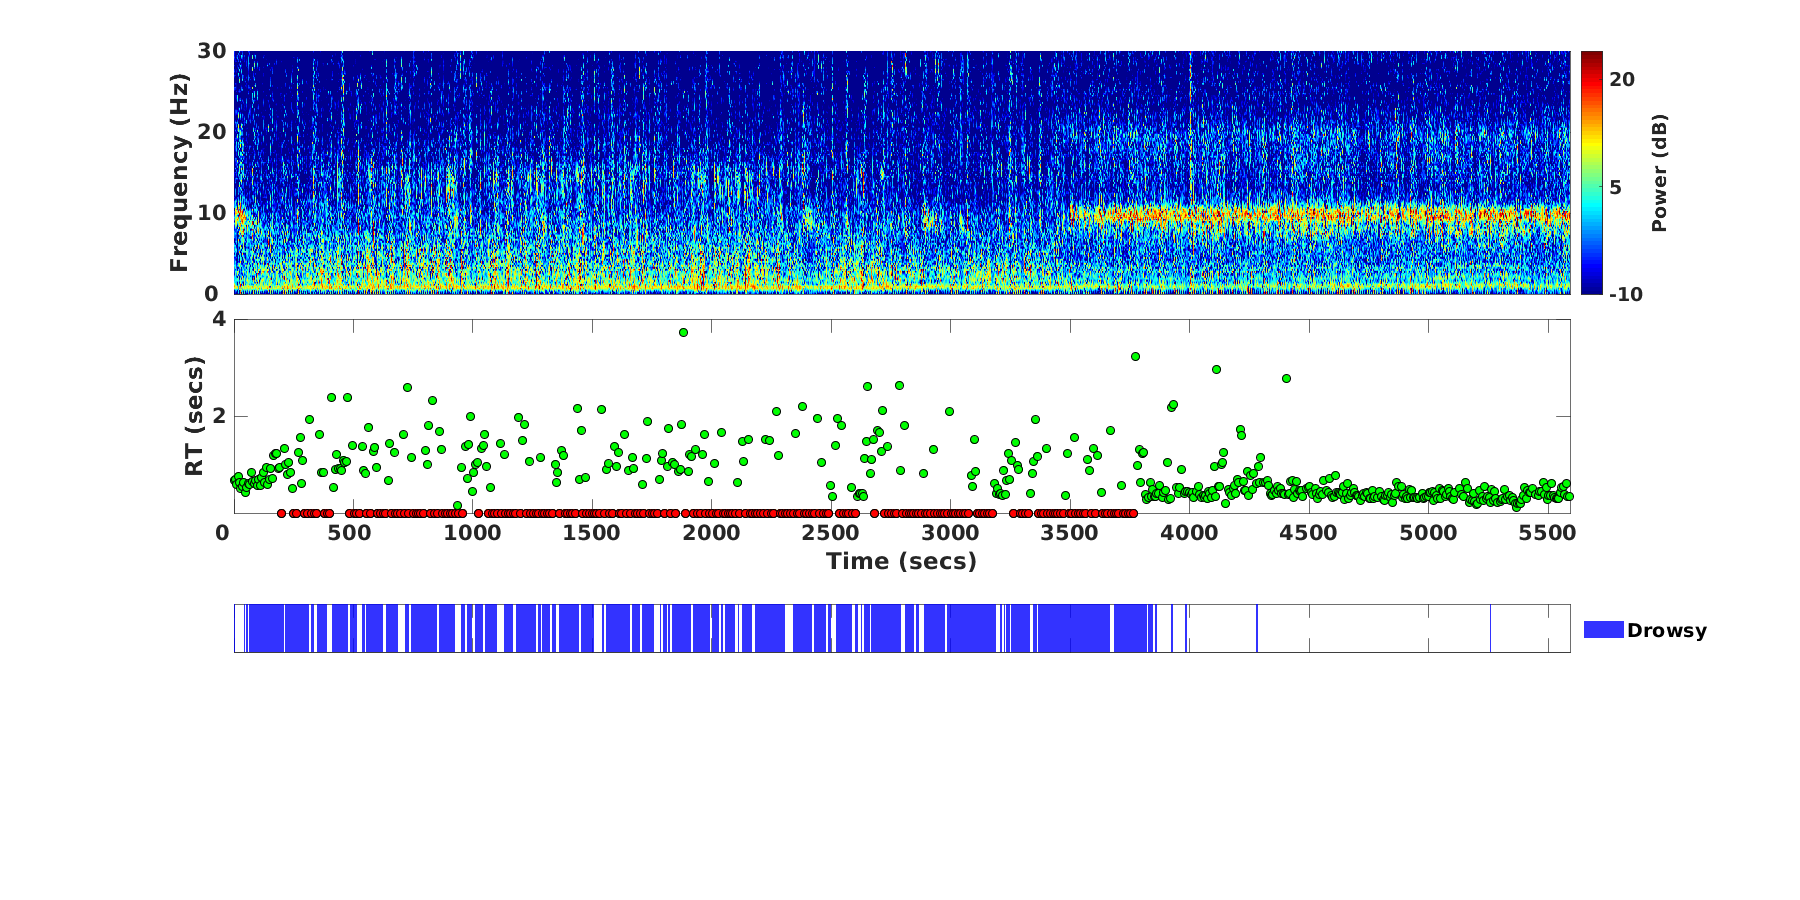

In [15]:
%% 7. Plotting the data..
if strcmp(session,'awake')
    figure('rend','painters','pos',[10 10 1200 600])
    fontsize = 12;
else
    figure('rend','painters','pos',[10 10 1800 900])
    fontsize = 16;
end

% Get the width and height of the figure
lbwh = get(1, 'position');
figw = lbwh(3);
figh = lbwh(4);

h = subplot(3,1,1);
ax1 = h;
hRotate = uigettool(ancestor(h,'Figure'),'Exploration.Rotate');
colormap jet
clims = [-10 max(max(Pxx_plot))];
hndl = pcolor(time, f_plot, Pxx_plot);
shading interp;
hndl.Parent.YDir = 'normal';
cblabel = getString(message('signal:dspdata:dspdata:PowerdB'));
h = colorbar;
h.Label.String = cblabel;
ylbl=['Frequency (Hz)'];
ylabel(ylbl);

if strcmp(session,'awake')
   t_plotval = round(min(time)):100:round(max(time)); %1000 
else
    t_plotval = round(min(time)):500:round(max(time)); %1000
end

f_plotval = 0:10:30;
set(gca, 'YLim', [0, 30]);
set(gca, 'YTick', f_plotval);
set(gca, 'XTickLabel', []);
set(gca, 'XTick', t_plotval);
set(gca, 'YTickLabel', f_plotval);
set(gca, 'clim', clims);
set(h,'YTick',[-10:15:20]);
set(gca, 'FontName', 'Helevetica', 'FontSize', fontsize,'FontWeight','Bold');

hsp1 = get(ax1, 'Position');
set(ax1, 'Position', [1*hsp1(1) 0.95*hsp1(2) hsp1(3) 1.25*hsp1(4)]);
box on


Trialtime = usabletrialtimes;
reactiontime = usablereactiontimes;
reactiontime(isnan(reactiontime)) = 0;

Trialtime = Trialtime - min(Trialtime); %reset to zero for plot..

ax2 = subplot(3,1,2);
scatter(time,nan(1,length(time)));
hold on ;s=scatter(Trialtime,reactiontime,'g','filled');
s.LineWidth = 0.6;
s.MarkerEdgeColor = 'k';
s.MarkerFaceColor = 'g';

hold on; s = scatter(Trialtime(reactiontime == 0),reactiontime(reactiontime==0),'r','filled');
s.LineWidth = 0.6;
s.MarkerEdgeColor = 'k';
s.MarkerFaceColor = 'r';

set(ax2,'Xlim',[round(min(time)) round(max(time))]);
set(ax2,'XTick',t_plotval);
set(gca, 'YTick', [2, 4]);
set(gca, 'YLim', [0, 4]);
set(gca, 'XTickLabel', [0 5]);
set(ax2, 'XTickLabel', t_plotval);
hsp2 = get(ax2, 'Position');                   % Get 'Position' for (2,1,2)
set(ax2, 'Position', [1*hsp2(1) 1.05*hsp2(2) hsp1(3) 1*hsp2(4)]);
xlbl=['Time (secs)'];
ylbl=['RT (secs)'];
ylabel(ylbl);
xlabel(xlbl);
set(gca, 'FontName', 'Helevetica', 'FontSize', fontsize,'FontWeight','Bold');
set(gca, 'color', [0.9 0.9 0.9])
box on

ax3 = subplot(3,1,3);

set(ax3,'Xlim',[0 round(max(time))]);
hsp3 = get(ax3, 'Position');
set(ax3, 'Position', [1*hsp3(1) 2.5*hsp3(2) hsp1(3) 0.25*hsp3(4)]);
alpha(.5)

if strcmp(session,'awake')
    alert_indexes = find(strcmp(usableclassification, 'Alert'));
    for idx = 1:length(alert_indexes)
        hold on;
        trial_start = Trialtime(alert_indexes(idx));
        if (alert_indexes(idx)+1) > length(Trialtime)
            trial_end = round(max(time));
        else
            trial_end = Trialtime(alert_indexes(idx)+1);
        end
        
        h1 = area([trial_start trial_end], [1 1],'FaceColor','r','LineStyle','none');
        h1.FaceAlpha = 0.8;
    end
    
else
    drowsy_indexes = find(strcmp(usableclassification, 'Drowsy'));
    for idx = 1:length(drowsy_indexes)
        hold on;
        trial_start = Trialtime(drowsy_indexes(idx));
        trial_end = Trialtime(drowsy_indexes(idx)+1);
        h1 = area([trial_start trial_end], [1 1],'FaceColor','b','LineStyle','none');
        h1.FaceAlpha = 0.8;
    end
    
end



set(ax3,'YTick',[]);
set(ax3, 'YTickLabel', []);
set(ax3,'Xlim',[round(min(time)) round(max(time))]);
set(ax3,'XTick',t_plotval);
set(ax3, 'XTickLabel', []);

%# add legend to middle one
if strcmp(session,'awake')
    legh = legend(ax3, h1,{'Alert'}); pos = get(legh,'position');
else
    legh = legend(ax3, h1,{'Drowsy'}); pos = get(legh,'position');
end

set(legh, 'position',[1.20*hsp1(3) 1.35*hsp3(4) pos(3:4)])
legend boxoff

set(ax3, 'FontName', 'Helevetica', 'FontSize', fontsize,'FontWeight','Bold');
set(ax3, 'color', [0.9 0.9 0.9])
box on

%samexaxis('xmt','off','ytac','join','yld',1)
%linkaxes([ax1,ax2],'x')

fig = gcf;
fig.Color = 'white';
saveas(gcf,[ outputpath 's_' subj '_' session '_spectrum.png']);